In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/noshowappointments/KaggleV2-May-2016.csv


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Makine Öğrenmesi Kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("=== MEDICAL APPOINTMENT NO-SHOW ANALYSIS ===")
print("Kütüphaneler başarıyla yüklendi!")

=== MEDICAL APPOINTMENT NO-SHOW ANALYSIS ===
Kütüphaneler başarıyla yüklendi!


In [25]:
# ====================
# 1. VERİ YÜKLEME VE İLK İNCELEME
# ====================

print("\n=== GERÇEK VERİ YÜKLENİYOR ===")

# Gerçek veri setini yükle
df = pd.read_csv('/kaggle/input/noshowappointments/KaggleV2-May-2016.csv')

print(f"✅ Veri başarıyla yüklendi!")
print(f"Veri boyutu: {df.shape[0]:,} satır x {df.shape[1]} sütun")
print(f"Toplam hücre sayısı: {df.size:,}")

print(f"\nSütun isimleri:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\n=== İLK VERİ İNCELEMESİ ===")
print(df.head())

print(f"\n=== VERİ TİPLERİ ===")
print(df.dtypes)

print(f"\n=== EKSİK DEĞERLER ===")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("✅ Hiç eksik değer yok!")
else:
    print("❌ Eksik değerler:")
    print(missing_values[missing_values > 0])

print(f"\n=== TEMEL İSTATİSTİKLER ===")
print(df.describe())

# No-show dağılımı
no_show_counts = df['No-show'].value_counts()
no_show_rate = (df['No-show'] == 'Yes').mean()
print(f"\n=== HEDEF DEĞİŞKEN DAĞILIMI ===")
print(f"Toplam randevu: {len(df):,}")
print(f"Geldi (No): {no_show_counts.get('No', 0):,} ({(no_show_counts.get('No', 0)/len(df)):.1%})")
print(f"Gelmedi (Yes): {no_show_counts.get('Yes', 0):,} ({no_show_rate:.1%})")

# Yaş dağılımına bakış
print(f"\n=== YAŞ DAĞILIMI ===")
print(f"En küçük yaş: {df['Age'].min()}")
print(f"En büyük yaş: {df['Age'].max()}")
print(f"Ortalama yaş: {df['Age'].mean():.1f}")
print(f"Negatif yaş sayısı: {(df['Age'] < 0).sum()}")

# Neighborhood sayısı
print(f"\n=== MAHALLE BİLGİSİ ===")
print(f"Toplam mahalle sayısı: {df['Neighbourhood'].nunique()}")
print(f"En fazla randevuya sahip 5 mahalle:")
top_neighbourhoods = df['Neighbourhood'].value_counts().head()
for i, (neighbourhood, count) in enumerate(top_neighbourhoods.items(), 1):
    print(f"{i}. {neighbourhood}: {count:,} randevu")


=== GERÇEK VERİ YÜKLENİYOR ===
✅ Veri başarıyla yüklendi!
Veri boyutu: 110,527 satır x 14 sütun
Toplam hücre sayısı: 1,547,378

Sütun isimleri:
 1. PatientId
 2. AppointmentID
 3. Gender
 4. ScheduledDay
 5. AppointmentDay
 6. Age
 7. Neighbourhood
 8. Scholarship
 9. Hipertension
10. Diabetes
11. Alcoholism
12. Handcap
13. SMS_received
14. No-show

=== İLK VERİ İNCELEMESİ ===
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  201

In [26]:
# ====================
# 2. VERİ ÖN İŞLEME VE KEŞİFSEL ANALİZ
# ====================

print("\n=== VERİ ÖN İŞLEME VE TEMİZLEME ===")

# Kopya oluştur
df_processed = df.copy()

# Negatif yaşları düzelt
negative_age_count = (df_processed['Age'] < 0).sum()
if negative_age_count > 0:
    print(f"⚠️ {negative_age_count} negatif yaş değeri bulundu, pozitif yapılacak")
    df_processed['Age'] = df_processed['Age'].abs()

# Tarih işlemleri
print("📅 Tarih sütunları işleniyor...")
df_processed['AppointmentDay'] = pd.to_datetime(df_processed['AppointmentDay'])
df_processed['ScheduledDay'] = pd.to_datetime(df_processed['ScheduledDay'])
df_processed['WaitingDays'] = (df_processed['AppointmentDay'] - df_processed['ScheduledDay']).dt.days

# Negatif bekleme günleri analizi
negative_waiting = (df_processed['WaitingDays'] < 0).sum()
print(f"Negatif bekleme günü olan randevu sayısı: {negative_waiting:,}")
if negative_waiting > 0:
    print("(Bu randevular muhtemelen aynı gün planlandı)")
    # Negatif değerleri 0 yap
    df_processed.loc[df_processed['WaitingDays'] < 0, 'WaitingDays'] = 0

print(f"✅ Veri temizleme tamamlandı")


=== VERİ ÖN İŞLEME VE TEMİZLEME ===
⚠️ 1 negatif yaş değeri bulundu, pozitif yapılacak
📅 Tarih sütunları işleniyor...
Negatif bekleme günü olan randevu sayısı: 38,568
(Bu randevular muhtemelen aynı gün planlandı)
✅ Veri temizleme tamamlandı



=== KEŞİFSEL VERİ ANALİZİ ===


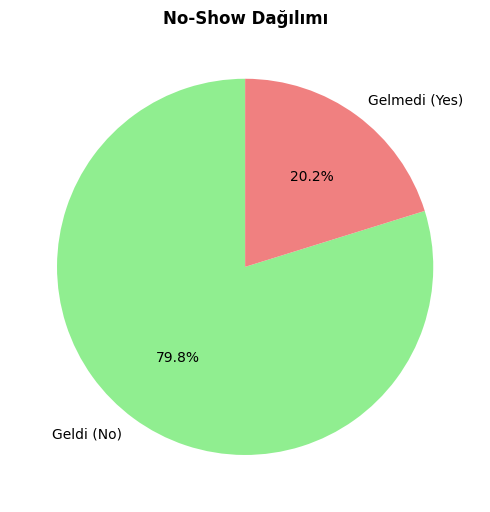

In [27]:
# ====================
# 3. KEŞİFSEL VERİ ANALİZİ (EDA)
# ====================

print("\n=== KEŞİFSEL VERİ ANALİZİ ===")

# Temel görselleştirmeler
plt.figure(figsize=(20, 15))

# 1. No-show dağılımı
plt.subplot(3, 4, 1)
no_show_counts = df_processed['No-show'].value_counts()
colors = ['lightgreen', 'lightcoral']
plt.pie(no_show_counts.values, labels=['Geldi (No)', 'Gelmedi (Yes)'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('No-Show Dağılımı', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

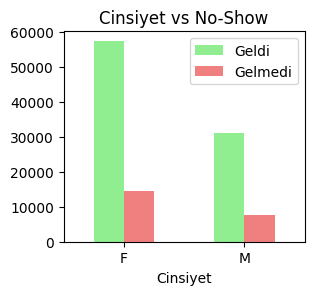

In [28]:
# 2. Cinsiyet vs No-show
plt.subplot(3, 4, 2)
gender_noshow = pd.crosstab(df_processed['Gender'], df_processed['No-show'])
gender_noshow.plot(kind='bar', ax=plt.gca(), color=colors)
plt.title('Cinsiyet vs No-Show')
plt.xlabel('Cinsiyet')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

plt.tight_layout()
plt.show()

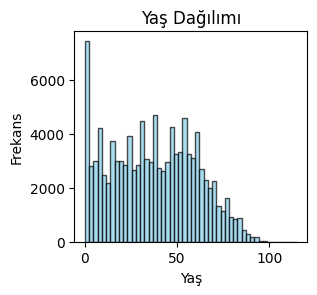

In [29]:
# 3. Yaş dağılımı
plt.subplot(3, 4, 3)
plt.hist(df_processed['Age'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Yaş Dağılımı')
plt.xlabel('Yaş')
plt.ylabel('Frekans')

plt.tight_layout()
plt.show()

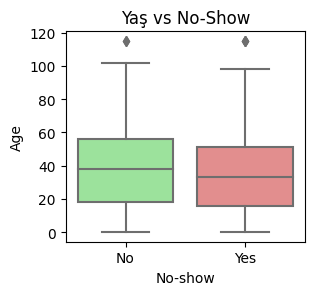

In [30]:
# 4. Yaş vs No-show
plt.subplot(3, 4, 4)
sns.boxplot(data=df_processed, x='No-show', y='Age', palette=colors)
plt.title('Yaş vs No-Show')

plt.tight_layout()
plt.show()

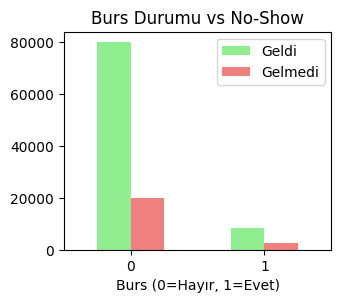

In [31]:
# 5. Burs durumu
plt.subplot(3, 4, 5)
scholarship_noshow = pd.crosstab(df_processed['Scholarship'], df_processed['No-show'])
scholarship_noshow.plot(kind='bar', ax=plt.gca(), color=colors)
plt.title('Burs Durumu vs No-Show')
plt.xlabel('Burs (0=Hayır, 1=Evet)')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

plt.tight_layout()
plt.show()

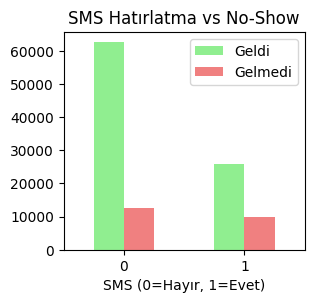

In [32]:
# 6. SMS durumu
plt.subplot(3, 4, 6)
sms_noshow = pd.crosstab(df_processed['SMS_received'], df_processed['No-show'])
sms_noshow.plot(kind='bar', ax=plt.gca(), color=colors)
plt.title('SMS Hatırlatma vs No-Show')
plt.xlabel('SMS (0=Hayır, 1=Evet)')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

plt.tight_layout()
plt.show()

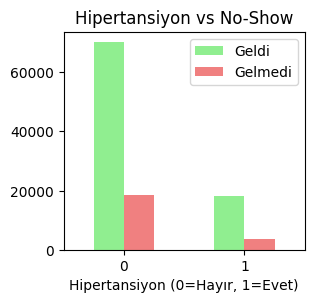

In [33]:
# 7. Hipertansiyon
plt.subplot(3, 4, 7)
hypertension_noshow = pd.crosstab(df_processed['Hipertension'], df_processed['No-show'])
hypertension_noshow.plot(kind='bar', ax=plt.gca(), color=colors)
plt.title('Hipertansiyon vs No-Show')
plt.xlabel('Hipertansiyon (0=Hayır, 1=Evet)')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

plt.tight_layout()
plt.show()

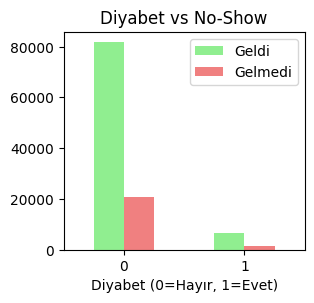

In [34]:
# 8. Diyabet
plt.subplot(3, 4, 8)
diabetes_noshow = pd.crosstab(df_processed['Diabetes'], df_processed['No-show'])
diabetes_noshow.plot(kind='bar', ax=plt.gca(), color=colors)
plt.title('Diyabet vs No-Show')
plt.xlabel('Diyabet (0=Hayır, 1=Evet)')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

plt.tight_layout()
plt.show()

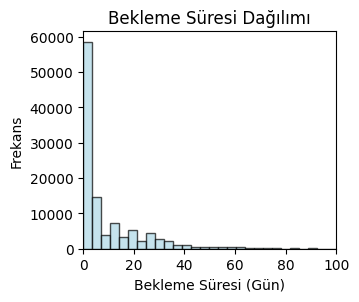

In [35]:
# 9. Bekleme süresi dağılımı
plt.subplot(3, 4, 9)
plt.hist(df_processed['WaitingDays'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Bekleme Süresi Dağılımı')
plt.xlabel('Bekleme Süresi (Gün)')
plt.ylabel('Frekans')
plt.xlim(0, min(100, df_processed['WaitingDays'].max()))

plt.tight_layout()
plt.show()

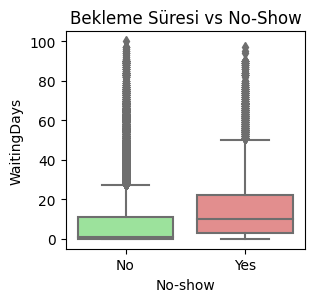

In [36]:
# 10. Bekleme süresi vs No-show
plt.subplot(3, 4, 10)
waiting_filtered = df_processed[df_processed['WaitingDays'] <= 100]  # İlk 100 günle sınırla
sns.boxplot(data=waiting_filtered, x='No-show', y='WaitingDays', palette=colors)
plt.title('Bekleme Süresi vs No-Show')

plt.tight_layout()
plt.show()

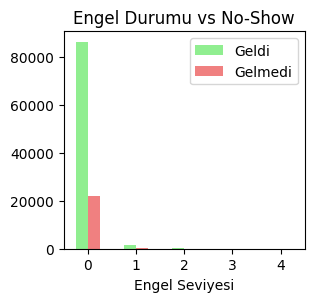

In [37]:
# 11. Engel durumu
plt.subplot(3, 4, 11)
handcap_noshow = pd.crosstab(df_processed['Handcap'], df_processed['No-show'])
handcap_noshow.plot(kind='bar', ax=plt.gca(), color=colors)
plt.title('Engel Durumu vs No-Show')
plt.xlabel('Engel Seviyesi')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

plt.tight_layout()
plt.show()

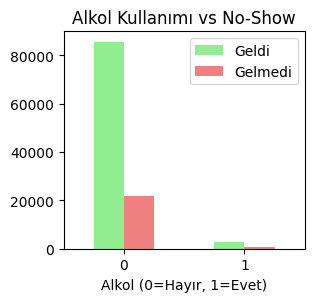

In [38]:
# 12. Alkol kullanımı
plt.subplot(3, 4, 12)
alcohol_noshow = pd.crosstab(df_processed['Alcoholism'], df_processed['No-show'])
alcohol_noshow.plot(kind='bar', ax=plt.gca(), color=colors)
plt.title('Alkol Kullanımı vs No-Show')
plt.xlabel('Alkol (0=Hayır, 1=Evet)')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

plt.tight_layout()
plt.show()

In [39]:
# İstatistik özetleri
print(f"\n=== ÖNEMLI İSTATİSTİKLER ===")
print(f"Ortalama bekleme süresi: {df_processed['WaitingDays'].mean():.1f} gün")
print(f"Medyan bekleme süresi: {df_processed['WaitingDays'].median():.0f} gün")
print(f"En uzun bekleme: {df_processed['WaitingDays'].max()} gün")

# Kategorik değişkenler için no-show oranları
categorical_vars = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']
print(f"\n=== KATEGORİK DEĞİŞKENLER İÇİN NO-SHOW ORANLARI ===")
for var in categorical_vars:
    if var in df_processed.columns:
        rates = df_processed.groupby(var)['No-show'].apply(lambda x: (x == 'Yes').mean())
        print(f"{var}:")
        for category, rate in rates.items():
            print(f"  {category}: {rate:.1%}")
        print()


=== ÖNEMLI İSTATİSTİKLER ===
Ortalama bekleme süresi: 9.5 gün
Medyan bekleme süresi: 3 gün
En uzun bekleme: 178 gün

=== KATEGORİK DEĞİŞKENLER İÇİN NO-SHOW ORANLARI ===
Gender:
  F: 20.3%
  M: 20.0%

Scholarship:
  0: 19.8%
  1: 23.7%

Hipertension:
  0: 20.9%
  1: 17.3%

Diabetes:
  0: 20.4%
  1: 18.0%

Alcoholism:
  0: 20.2%
  1: 20.1%

SMS_received:
  0: 16.7%
  1: 27.6%



In [40]:
# ====================
# 4. ÖZELLİK MÜHENDİSLİĞİ
# ====================

print("\n=== ÖZELLİK MÜHENDİSLİĞİ ===")

# Yeni özellikler oluştur
print("🔧 Yeni özellikler oluşturuluyor...")

# 1. Yaş grupları
df_processed['AgeGroup'] = pd.cut(df_processed['Age'], 
                                bins=[0, 18, 35, 50, 65, 120], 
                                labels=['Child', 'Young_Adult', 'Adult', 'Middle_Age', 'Senior'])

# 2. Bekleme süresi kategorileri
df_processed['WaitingCategory'] = pd.cut(df_processed['WaitingDays'], 
                                       bins=[-1, 0, 7, 30, 365], 
                                       labels=['Same_Day', 'Within_Week', 'Within_Month', 'Long_Wait'])

# 3. Toplam sağlık problemi sayısı
health_conditions = ['Hipertension', 'Diabetes', 'Alcoholism']
df_processed['HealthIssueCount'] = df_processed[health_conditions].sum(axis=1)

# 4. Hafta günü bilgileri
df_processed['AppointmentWeekday'] = df_processed['AppointmentDay'].dt.day_name()
df_processed['IsWeekend'] = df_processed['AppointmentWeekday'].isin(['Saturday', 'Sunday']).astype(int)

# 5. Randevu ayı
df_processed['AppointmentMonth'] = df_processed['AppointmentDay'].dt.month

# 6. Yaş-SMS etkileşimi
df_processed['Age_SMS_Interaction'] = df_processed['Age'] * df_processed['SMS_received']

# 7. Bekleme-SMS etkileşimi
df_processed['Waiting_SMS_Interaction'] = df_processed['WaitingDays'] * df_processed['SMS_received']

# Hedef değişken kodlama
df_processed['No_show_encoded'] = (df_processed['No-show'] == 'Yes').astype(int)

print("✅ Yeni özellikler oluşturuldu:")
print("- AgeGroup: Yaş grupları (5 kategori)")
print("- WaitingCategory: Bekleme süresi kategorileri (4 kategori)")  
print("- HealthIssueCount: Toplam sağlık problemi sayısı")
print("- IsWeekend: Hafta sonu randevu bilgisi")
print("- AppointmentMonth: Randevu ayı")
print("- Age_SMS_Interaction: Yaş-SMS etkileşimi")
print("- Waiting_SMS_Interaction: Bekleme-SMS etkileşimi")


=== ÖZELLİK MÜHENDİSLİĞİ ===
🔧 Yeni özellikler oluşturuluyor...
✅ Yeni özellikler oluşturuldu:
- AgeGroup: Yaş grupları (5 kategori)
- WaitingCategory: Bekleme süresi kategorileri (4 kategori)
- HealthIssueCount: Toplam sağlık problemi sayısı
- IsWeekend: Hafta sonu randevu bilgisi
- AppointmentMonth: Randevu ayı
- Age_SMS_Interaction: Yaş-SMS etkileşimi
- Waiting_SMS_Interaction: Bekleme-SMS etkileşimi


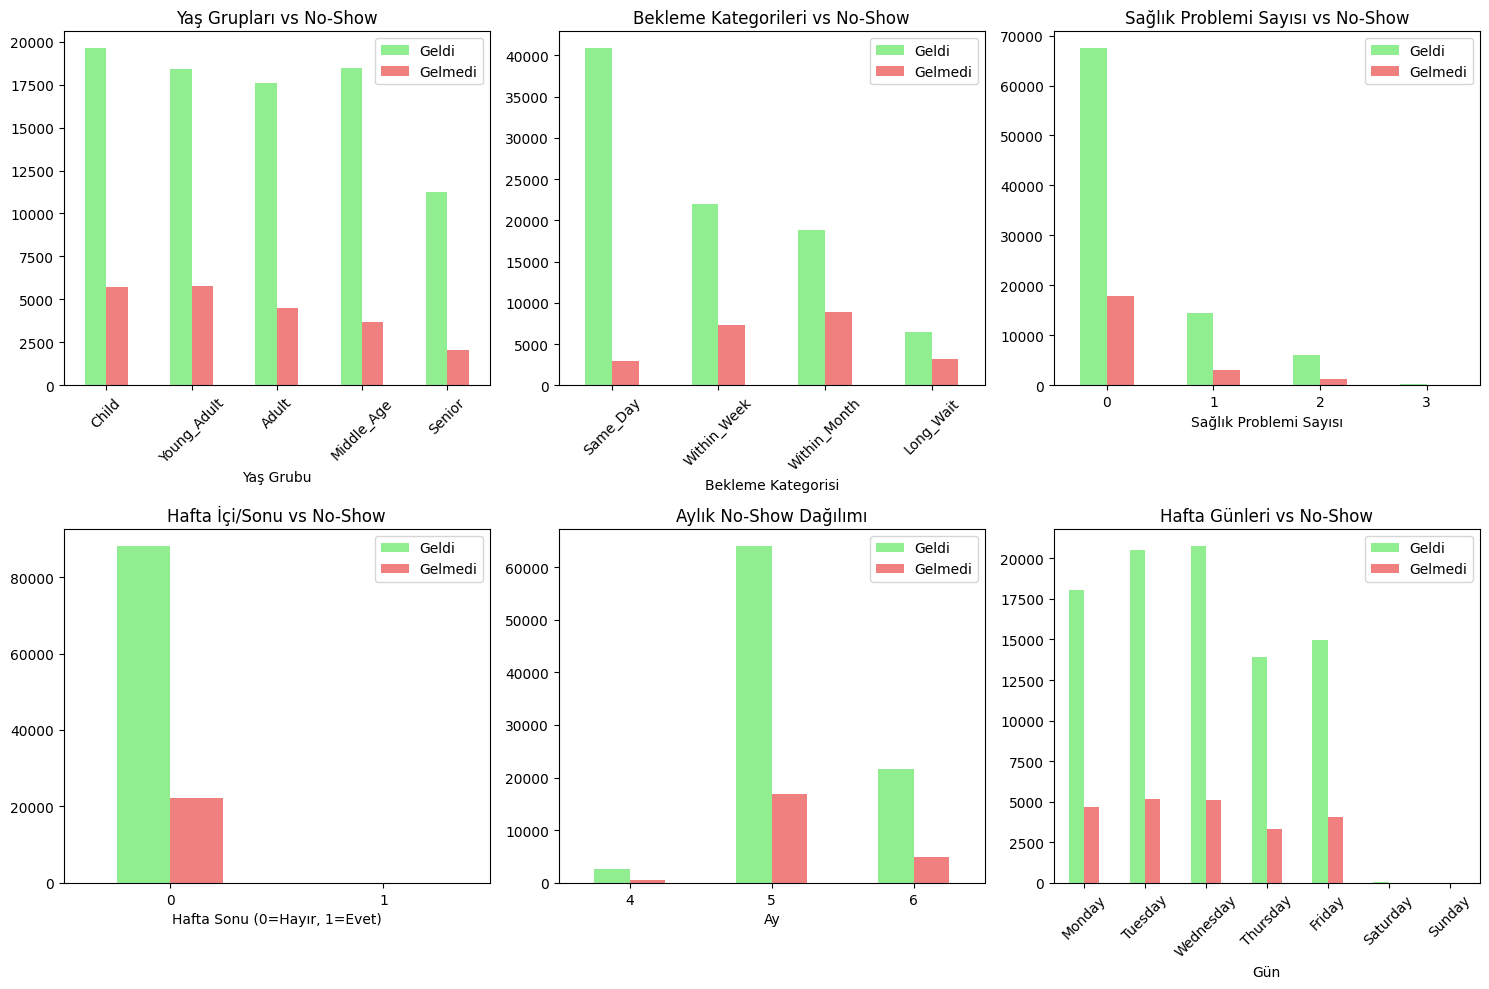

In [41]:
# Yeni özellikler hakkında görsel analiz
plt.figure(figsize=(15, 10))

# Yaş grupları vs No-show
plt.subplot(2, 3, 1)
age_group_noshow = pd.crosstab(df_processed['AgeGroup'], df_processed['No-show'])
age_group_noshow.plot(kind='bar', ax=plt.gca(), color=['lightgreen', 'lightcoral'])
plt.title('Yaş Grupları vs No-Show')
plt.xlabel('Yaş Grubu')
plt.xticks(rotation=45)
plt.legend(['Geldi', 'Gelmedi'])

# Bekleme kategorileri vs No-show
plt.subplot(2, 3, 2)
waiting_cat_noshow = pd.crosstab(df_processed['WaitingCategory'], df_processed['No-show'])
waiting_cat_noshow.plot(kind='bar', ax=plt.gca(), color=['lightgreen', 'lightcoral'])
plt.title('Bekleme Kategorileri vs No-Show')
plt.xlabel('Bekleme Kategorisi')
plt.xticks(rotation=45)
plt.legend(['Geldi', 'Gelmedi'])

# Sağlık problemi sayısı vs No-show
plt.subplot(2, 3, 3)
health_count_noshow = pd.crosstab(df_processed['HealthIssueCount'], df_processed['No-show'])
health_count_noshow.plot(kind='bar', ax=plt.gca(), color=['lightgreen', 'lightcoral'])
plt.title('Sağlık Problemi Sayısı vs No-Show')
plt.xlabel('Sağlık Problemi Sayısı')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

# Hafta sonu vs No-show
plt.subplot(2, 3, 4)
weekend_noshow = pd.crosstab(df_processed['IsWeekend'], df_processed['No-show'])
weekend_noshow.plot(kind='bar', ax=plt.gca(), color=['lightgreen', 'lightcoral'])
plt.title('Hafta İçi/Sonu vs No-Show')
plt.xlabel('Hafta Sonu (0=Hayır, 1=Evet)')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

# Aylık dağılım
plt.subplot(2, 3, 5)
monthly_noshow = pd.crosstab(df_processed['AppointmentMonth'], df_processed['No-show'])
monthly_noshow.plot(kind='bar', ax=plt.gca(), color=['lightgreen', 'lightcoral'])
plt.title('Aylık No-Show Dağılımı')
plt.xlabel('Ay')
plt.xticks(rotation=0)
plt.legend(['Geldi', 'Gelmedi'])

# Hafta günleri
plt.subplot(2, 3, 6)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_noshow = pd.crosstab(df_processed['AppointmentWeekday'], df_processed['No-show'])
weekday_noshow = weekday_noshow.reindex(weekday_order, fill_value=0)
weekday_noshow.plot(kind='bar', ax=plt.gca(), color=['lightgreen', 'lightcoral'])
plt.title('Hafta Günleri vs No-Show')
plt.xlabel('Gün')
plt.xticks(rotation=45)
plt.legend(['Geldi', 'Gelmedi'])

plt.tight_layout()
plt.show()

In [42]:
print(f"\n=== ÖZELLİK MÜHENDİSLİĞİ İSTATİSTİKLERİ ===")
print(f"Yaş grupları dağılımı:")
for group, count in df_processed['AgeGroup'].value_counts().sort_index().items():
    print(f"  {group}: {count:,} kişi")

print(f"\nBekleme kategorileri:")
for cat, count in df_processed['WaitingCategory'].value_counts().sort_index().items():
    print(f"  {cat}: {count:,} randevu")

print(f"\nSağlık problemi dağılımı:")
for count, freq in df_processed['HealthIssueCount'].value_counts().sort_index().items():
    print(f"  {count} problem: {freq:,} kişi ({freq/len(df_processed):.1%})")

print(f"\nHafta sonu randevu oranı: {df_processed['IsWeekend'].mean():.1%}")

# En fazla randevuya sahip mahalleler
print(f"\n=== TOP 10 MAHALLE (RANDEVU SAYISI) ===")
top_neighbourhoods = df_processed['Neighbourhood'].value_counts().head(10)
for i, (neighbourhood, count) in enumerate(top_neighbourhoods.items(), 1):
    no_show_rate = df_processed[df_processed['Neighbourhood'] == neighbourhood]['No-show'].apply(lambda x: x == 'Yes').mean()
    print(f"{i:2d}. {neighbourhood}: {count:,} randevu (No-show: {no_show_rate:.1%})")


=== ÖZELLİK MÜHENDİSLİĞİ İSTATİSTİKLERİ ===
Yaş grupları dağılımı:
  Child: 25,328 kişi
  Young_Adult: 24,137 kişi
  Adult: 22,100 kişi
  Middle_Age: 22,122 kişi
  Senior: 13,301 kişi

Bekleme kategorileri:
  Same_Day: 43,781 randevu
  Within_Week: 29,304 randevu
  Within_Month: 27,736 randevu
  Long_Wait: 9,706 randevu

Sağlık problemi dağılımı:
  0 problem: 85,312 kişi (77.2%)
  1 problem: 17,582 kişi (15.9%)
  2 problem: 7,377 kişi (6.7%)
  3 problem: 256 kişi (0.2%)

Hafta sonu randevu oranı: 0.0%

=== TOP 10 MAHALLE (RANDEVU SAYISI) ===
 1. JARDIM CAMBURI: 7,717 randevu (No-show: 19.0%)
 2. MARIA ORTIZ: 5,805 randevu (No-show: 21.0%)
 3. RESISTÊNCIA: 4,431 randevu (No-show: 20.4%)
 4. JARDIM DA PENHA: 3,877 randevu (No-show: 16.3%)
 5. ITARARÉ: 3,514 randevu (No-show: 26.3%)
 6. CENTRO: 3,334 randevu (No-show: 21.1%)
 7. TABUAZEIRO: 3,132 randevu (No-show: 18.3%)
 8. SANTA MARTHA: 3,131 randevu (No-show: 15.8%)
 9. JESUS DE NAZARETH: 2,853 randevu (No-show: 24.4%)
10. BONFIM: 2,7

In [43]:
# ====================
# 5. KATEGORİK DEĞİŞKEN KODLAMA
# ====================

print("\n=== KATEGORİK DEĞİŞKEN KODLAMA ===")

# Binary kodlama
df_processed['Gender_encoded'] = (df_processed['Gender'] == 'M').astype(int)

# Mahalle frequency encoding
neighbourhood_freq = df_processed['Neighbourhood'].value_counts()
df_processed['Neighbourhood_freq'] = df_processed['Neighbourhood'].map(neighbourhood_freq)

# One-hot encoding
categorical_cols = ['AgeGroup', 'WaitingCategory']
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"Kodlama sonrası toplam özellik sayısı: {df_encoded.shape[1]}")

# ====================
# 4. ÖZELLİK SEÇİMİ VE VERİ HAZIRLIĞI
# ====================

print("\n=== ÖZELLİK SEÇİMİ ===")

# Modelleme için kullanılmayacak kolonlar
exclude_columns = [
    'PatientId', 'AppointmentID', 'No-show', 'No_show_encoded',
    'AppointmentDay', 'ScheduledDay', 'Neighbourhood', 'Gender',
    'AgeGroup', 'WaitingCategory', 'AppointmentWeekday'
]

# Mevcut kolonlardan exclude edilecekleri çıkar
feature_columns = [col for col in df_encoded.columns if col not in exclude_columns]

X = df_encoded[feature_columns]
y = df_encoded['No_show_encoded']

print(f"Modelleme için kullanılan özellik sayısı: {len(feature_columns)}")
print(f"Özellikler: {feature_columns}")

# Eksik değerleri kontrol et ve doldur
if X.isnull().sum().sum() > 0:
    print("⚠️ Eksik değerler bulundu, medyan ile doldurulacak")
    X = X.fillna(X.median())

# ====================
# 5. VERİ BÖLME VE ÖLÇEKLEME
# ====================

print("\n=== VERİ BÖLME VE ÖLÇEKLEME ===")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Eğitim seti: {X_train.shape[0]:,} örnek")
print(f"Test seti: {X_test.shape[0]:,} örnek")
print(f"Eğitim seti No-show oranı: {y_train.mean():.1%}")
print(f"Test seti No-show oranı: {y_test.mean():.1%}")

# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Veriler ölçeklendirildi")


=== KATEGORİK DEĞİŞKEN KODLAMA ===
Kodlama sonrası toplam özellik sayısı: 31

=== ÖZELLİK SEÇİMİ ===
Modelleme için kullanılan özellik sayısı: 22
Özellikler: ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'WaitingDays', 'HealthIssueCount', 'IsWeekend', 'AppointmentMonth', 'Age_SMS_Interaction', 'Waiting_SMS_Interaction', 'Gender_encoded', 'Neighbourhood_freq', 'AgeGroup_Young_Adult', 'AgeGroup_Adult', 'AgeGroup_Middle_Age', 'AgeGroup_Senior', 'WaitingCategory_Within_Week', 'WaitingCategory_Within_Month', 'WaitingCategory_Long_Wait']

=== VERİ BÖLME VE ÖLÇEKLEME ===
Eğitim seti: 88,421 örnek
Test seti: 22,106 örnek
Eğitim seti No-show oranı: 20.2%
Test seti No-show oranı: 20.2%
✅ Veriler ölçeklendirildi


In [44]:
# ====================
# 6. MODEL KARŞILAŞTIRMA
# ====================

print("\n=== MODEL KARŞILAŞTIRMA ===")

# Modelleri tanımla
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}

for name, model in models.items():
    print(f"\n{name} değerlendiriliyor...")
    
    # Ölçekleme gerektiren modeller
    if name in ['KNN', 'Logistic Regression']:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    model_results[name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    
    print(f"F1-Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# En iyi modeli seç
best_model_name = max(model_results, key=lambda x: model_results[x]['mean'])
best_model = models[best_model_name]

print(f"\n🏆 En iyi model: {best_model_name}")
print(f"F1-Score: {model_results[best_model_name]['mean']:.4f}")


=== MODEL KARŞILAŞTIRMA ===

Logistic Regression değerlendiriliyor...
F1-Score: 0.0025 (+/- 0.0015)

Random Forest değerlendiriliyor...
F1-Score: 0.2631 (+/- 0.0114)

Gradient Boosting değerlendiriliyor...
F1-Score: 0.0083 (+/- 0.0031)

Decision Tree değerlendiriliyor...
F1-Score: 0.3243 (+/- 0.0049)

KNN değerlendiriliyor...
F1-Score: 0.2522 (+/- 0.0149)

🏆 En iyi model: Decision Tree
F1-Score: 0.3243


In [45]:
!pip install -U scikit-learn imbalanced-learn --quiet

In [46]:
print(y_train.value_counts(normalize=True))

No_show_encoded
0    0.798068
1    0.201932
Name: proportion, dtype: float64


In [47]:
pip install --upgrade imbalanced-learn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [48]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Eğitim ve test verisini zaten ayırdıysan bu kısmı atla
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE uygulama
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

# Ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_res_scaled = scaler.fit_transform(X_train_resampled)
X_test_res_scaled = scaler.transform(X_test)

# Modeller
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}

print("\n=== MODEL KARŞILAŞTIRMA (SMOTE sonrası) ===")
for name, model in models.items():
    print(f"\n{name} değerlendiriliyor...")

    if name in ['Logistic Regression', 'KNN']:
        scores = cross_val_score(model, X_train_res_scaled, y_train_resampled, cv=cv, scoring='f1')
    else:
        scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')

    model_results[name] = {'scores': scores, 'mean': scores.mean(), 'std': scores.std()}
    print(f"F1-Score: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

best_model_name = max(model_results, key=lambda x: model_results[x]['mean'])
best_model = models[best_model_name]

print(f"\n🏆 En iyi model: {best_model_name}")



=== MODEL KARŞILAŞTIRMA (SMOTE sonrası) ===

Logistic Regression değerlendiriliyor...
F1-Score: 0.6825 (+/- 0.0022)

Random Forest değerlendiriliyor...
F1-Score: 0.7770 (+/- 0.0030)

Gradient Boosting değerlendiriliyor...
F1-Score: 0.7121 (+/- 0.0043)

Decision Tree değerlendiriliyor...
F1-Score: 0.7587 (+/- 0.0048)

KNN değerlendiriliyor...
F1-Score: 0.7430 (+/- 0.0022)

🏆 En iyi model: Random Forest


In [50]:
print(f"SMOTE sonrası eğitim seti boyutu: {X_train_resampled.shape}")

SMOTE sonrası eğitim seti boyutu: (141132, 22)


In [51]:
pip install pandas scikit-learn numpy scipy imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import randint as sp_randint
from imblearn.over_sampling import SMOTE

# --- 1. Veri Seti Yükleme ---
df = pd.read_csv("/kaggle/input/noshowappointments/KaggleV2-May-2016.csv")

print(f"📊 Orijinal veri seti boyutu: {df.shape}")
print(f"📋 Sütun isimleri: {list(df.columns)}")
print(f"🔍 Eksik değerler:\n{df.isnull().sum()}")
print(f"📈 Hedef değişken dağılımı:\n{df['No-show'].value_counts()}")

# --- 2. Veri Ön İşleme ---
# Hedef değişkeni ayır
X = df.drop("No-show", axis=1)
y = df["No-show"]

# Hedef değişkeni sayısal değerlere çevir (Yes=1, No=0)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"🎯 Hedef kodlama: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# Kategorik ve numerik sütunları belirle
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"📝 Kategorik sütunlar: {categorical_columns}")
print(f"🔢 Numerik sütunlar: {numerical_columns}")

# X verilerinin bir kopyasını oluştur
X_processed = X.copy()

# Kategorik değişkenleri Label Encoding ile çevir
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    label_encoders[col] = le
    print(f"   ✅ {col} sütunu kodlandı: {X_processed[col].nunique()} benzersiz değer")

# Tarih sütunları varsa bunları da işle (datetime formatında olanlar)
date_columns = []
for col in X_processed.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        try:
            X_processed[col] = pd.to_datetime(X_processed[col], errors='coerce')
            # Tarih sütunlarını numerik değerlere çevir (timestamp)
            X_processed[col] = X_processed[col].astype('int64') // 10**9  # saniye cinsinden
            date_columns.append(col)
            print(f"   📅 {col} sütunu tarih olarak işlendi")
        except:
            pass

print(f"📅 İşlenen tarih sütunları: {date_columns}")

# Eksik değerleri doldur
if X_processed.isnull().sum().sum() > 0:
    # Numerik sütunlar için medyan
    for col in numerical_columns:
        if X_processed[col].isnull().sum() > 0:
            X_processed[col].fillna(X_processed[col].median(), inplace=True)
    
    # Kategorik sütunlar için mod (en sık görülen değer)
    for col in categorical_columns:
        if X_processed[col].isnull().sum() > 0:
            X_processed[col].fillna(X_processed[col].mode()[0], inplace=True)

print(f"✅ İşleme sonrası veri tipi kontrolü:")
print(X_processed.dtypes.value_counts())

# --- 3. Eğitim ve Test Setlerine Ayırma ---
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"\n📊 Eğitim seti boyutu: {X_train.shape}")
print(f"📊 Test seti boyutu: {X_test.shape}")
print(f"📈 Eğitim seti sınıf dağılımı: {pd.Series(y_train).value_counts().to_dict()}")

# --- 4. SMOTE Uygulaması ---
print("\n⚖️ SMOTE ile veri dengeleme...")
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print(f"✅ SMOTE sonrası eğitim seti boyutu: {X_train_resampled.shape}")
print(f"📈 SMOTE sonrası sınıf dağılımı: {pd.Series(y_train_resampled).value_counts().to_dict()}")

# --- 5. Random Forest ile Hiperparametre Optimizasyonu ---
print("\n🌲 Random Forest hiperparametre optimizasyonu başlıyor...")

rf = RandomForestClassifier(random_state=42)

# Parametre dağılımları
param_dist_rf = {
    'n_estimators': sp_randint(50, 150),
    'max_depth': [10, 15, 20, None],
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 5),
    'bootstrap': [True, False]
}

# RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("🔍 Hiperparametre araması başlatılıyor...")
random_search_rf.fit(X_train_resampled, y_train_resampled)

# --- 6. En İyi Model ve Sonuçlar ---
best_rf_model = random_search_rf.best_estimator_
print(f"\n🏆 En iyi parametreler: {random_search_rf.best_params_}")
print(f"📊 En iyi F1-Score (CV): {random_search_rf.best_score_:.4f}")

# --- 7. Test Seti Performansı ---
print("\n📈 Test seti performans değerlendirmesi...")
y_pred_test = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Metrikleri hesapla
f1 = f1_score(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("\n🎯 SONUÇLAR:")
print("=" * 40)
print(f"📊 Doğruluk (Accuracy): {accuracy:.4f}")
print(f"🎯 Kesinlik (Precision): {precision:.4f}")
print(f"🔍 Duyarlılık (Recall): {recall:.4f}")
print(f"⚖️ F1-Score: {f1:.4f}")
print(f"📈 AUC-ROC: {auc_roc:.4f}")
print("=" * 40)

# --- 8. Özellik Önemleri ---
print("\n🔍 En önemli özellikler:")
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

print("\n✅ Model eğitimi tamamlandı!")

📊 Orijinal veri seti boyutu: (110527, 14)
📋 Sütun isimleri: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
🔍 Eksik değerler:
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64
📈 Hedef değişken dağılımı:
No-show
No     88208
Yes    22319
Name: count, dtype: int64
🎯 Hedef kodlama: {'No': 0, 'Yes': 1}
📝 Kategorik sütunlar: ['Gender', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood']
🔢 Numerik sütunlar: ['PatientId', 'AppointmentID', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
   ✅ Gender sütunu kodlandı: 2 benzersiz değer
   ✅ ScheduledDay sütunu kodlandı: 103

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from scipy.stats import randint as sp_randint, uniform
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Scikit-learn modelleri, metrikleri ve yardımcı araçlar
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve,
    precision_recall_curve, average_precision_score # Bu fonksiyonlar dahil!
)
from scipy.stats import randint as sp_randint

# Dengesiz veri setleri için
from imblearn.over_sampling import SMOTE

In [54]:
# ====================
# 7. MODEL KARŞILAŞTIRMASI (SMOTE)
# ====================

print(f"\n🔍 Model karşılaştırması başlatılıyor...")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

model_results = {}
best_score = 0
best_model_name = ""

for name, model in models.items():
    print(f"   • {name} değerlendiriliyor...")
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                           cv=5, scoring='f1', n_jobs=-1)
    mean_score = scores.mean()
    std_score = scores.std()
    model_results[name] = {'mean': mean_score, 'std': std_score}
    
    if mean_score > best_score:
        best_score = mean_score
        best_model_name = name
    
    print(f"     F1-Score: {mean_score:.4f} (+/- {std_score:.4f})")

print(f"\n🏆 En iyi model: {best_model_name} (F1: {best_score:.4f})")



🔍 Model karşılaştırması başlatılıyor...
   • Logistic Regression değerlendiriliyor...
     F1-Score: 0.0000 (+/- 0.0000)
   • Random Forest değerlendiriliyor...
     F1-Score: 0.7737 (+/- 0.1472)
   • Gradient Boosting değerlendiriliyor...
     F1-Score: 0.7200 (+/- 0.1292)
   • Decision Tree değerlendiriliyor...
     F1-Score: 0.7252 (+/- 0.1088)
   • KNN değerlendiriliyor...
     F1-Score: 0.6625 (+/- 0.0160)

🏆 En iyi model: Random Forest (F1: 0.7737)


In [58]:
print(y.isna().sum())
df = df.dropna()

0


In [61]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 2. Hedef sütunu düzenle
df["no_show"] = df["no_show"].map({"Yes": 1, "No": 0})

# 3. Kategorik değişkenleri sayısal hale getir (One-hot encoding)
#df_encoded = pd.get_dummies(df.drop("no_show", axis=1), drop_first=True)

# 4. Özellikleri (X) ve hedefi (y) ayır
#X = df_encoded
#y = df["no_show"]

# 5. Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Random Forest modelini oluştur
best_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# 7. Modeli eğit
best_rf_model.fit(X_train, y_train)

# 8. Tahmin yap
y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1]


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [40]:
print(df.columns.tolist())

['patientid', 'appointmentid', 'gender', 'scheduledday', 'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension', 'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no_show', 'waiting_days']


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the dataset ---
try:
    df = pd.read_csv('/kaggle/input/noshowappointments/KaggleV2-May-2016.csv')
except FileNotFoundError:
    print("Error: Dataset not found. Please ensure the file is at '/kaggle/input/noshowappointments/KaggleV2-May-2016.csv'")
    exit()

# --- Data Preprocessing ---
# Rename columns for easier access
df.columns = df.columns.str.replace('-', '_').str.lower()

# Convert 'scheduledday' and 'appointmentday' to datetime objects
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

# Corrected: Create a feature for 'waiting_days' by directly subtracting datetime series
# and then accessing .dt.days on the resulting Timedelta Series.
df['waiting_days'] = (df['appointmentday'] - df['scheduledday']).dt.days

# Handle 'No-show' target variable: 'No' -> 0, 'Yes' -> 1
df['no_show'] = df['no_show'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop columns that are not useful for training or could cause data leakage
df_processed = df.drop(columns=['patientid', 'appointmentid', 'scheduledday', 'appointmentday', 'neighbourhood'])

# Convert categorical features to numerical using one-hot encoding
df_processed = pd.get_dummies(df_processed, columns=['gender', 'sms_received', 'scholarship', 'hipertension', 'diabetes', 'alcoholism', 'handcap'], drop_first=True)

# Separate features (X) and target (y)
X = df_processed.drop('no_show', axis=1)
y = df_processed['no_show']

# --- Split the data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Create and Train the Optimized Random Forest Model ---
print("💪 Random Forest model eğitiliyor...")
best_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    class_weight='balanced' # Helpful for imbalanced datasets like "no-show"
)
best_rf_model.fit(X_train, y_train)
print("✅ Model eğitimi tamamlandı!")

# --- Make predictions ---
y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

💪 Random Forest model eğitiliyor...
✅ Model eğitimi tamamlandı!


In [16]:
## Model Değerlendirme

print(f"\n📈 Model performansı değerlendiriliyor...")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"📊 Test seti performansı:")
print(f"  • **Doğruluk (Accuracy)**: {accuracy:.4f}")
print(f"  • **Kesinlik (Precision)**: {precision:.4f}")
print(f"  • **Duyarlılık (Recall)**: {recall:.4f}")
print(f"  • **F1-Score**: {f1:.4f}")
print(f"  • **AUC-ROC**: {auc:.4f}")


📈 Model performansı değerlendiriliyor...
📊 Test seti performansı:
  • **Doğruluk (Accuracy)**: 0.5853
  • **Kesinlik (Precision)**: 0.3063
  • **Duyarlılık (Recall)**: 0.8329
  • **F1-Score**: 0.4478
  • **AUC-ROC**: 0.7306



--- Karışıklık Matrisi (Confusion Matrix) ---
[[9220 8422]
 [ 746 3718]]


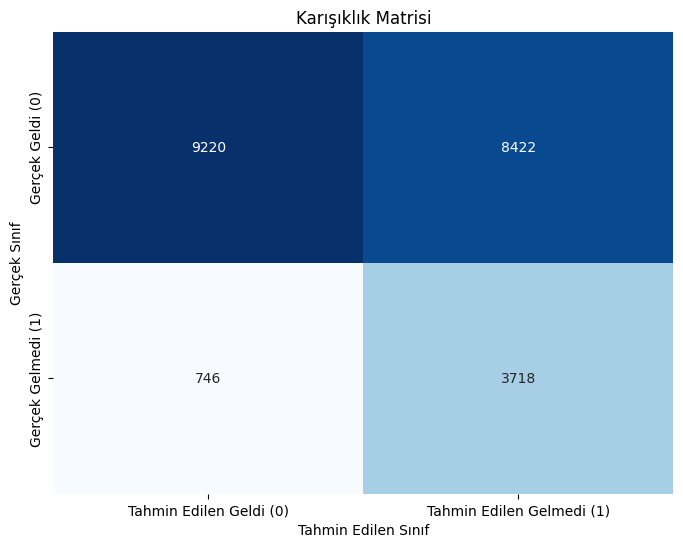


--- Sınıflandırma Raporu (Classification Report) ---
              precision    recall  f1-score   support

   Geldi (0)       0.93      0.52      0.67     17642
 Gelmedi (1)       0.31      0.83      0.45      4464

    accuracy                           0.59     22106
   macro avg       0.62      0.68      0.56     22106
weighted avg       0.80      0.59      0.62     22106


ROC Eğrisi çizmeden önce y_test boyutu: 22106
ROC Eğrisi çizmeden önce y_proba boyutu: 22106


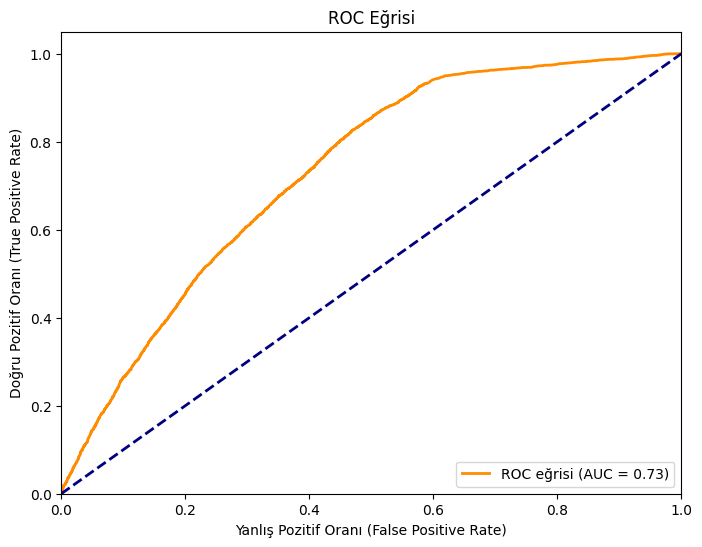


Model değerlendirme sonuçları '**model_results**' sözlüğüne eklendi: {'Optimized Random Forest': {'accuracy': 0.5852709671582376, 'precision': 0.30626029654036246, 'recall': 0.8328853046594982, 'f1': 0.44784389303782224, 'auc': <function auc at 0x7fa6cc558540>}}

=== DETAYLI SINIFLANDIRMA RAPORU ===
              precision    recall  f1-score   support

   Geldi (0)       0.93      0.52      0.67     17642
 Gelmedi (1)       0.31      0.83      0.45      4464

    accuracy                           0.59     22106
   macro avg       0.62      0.68      0.56     22106
weighted avg       0.80      0.59      0.62     22106


=== EN ÖNEMLİ ÖZELLİKLER ===
 1. waiting_days        : 0.7755
 2. age                 : 0.1200
 3. sms_received_1      : 0.0591
 4. gender_M            : 0.0101
 5. hipertension_1      : 0.0087
 6. scholarship_1       : 0.0078
 7. handcap_1           : 0.0060
 8. alcoholism_1        : 0.0059
 9. diabetes_1          : 0.0051
10. handcap_2           : 0.0016

=== ÖZET =

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Karışıklık Matrisi (Confusion Matrix)

print("\n--- Karışıklık Matrisi (Confusion Matrix) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tahmin Edilen Geldi (0)', 'Tahmin Edilen Gelmedi (1)'],
            yticklabels=['Gerçek Geldi (0)', 'Gerçek Gelmedi (1)'])
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karışıklık Matrisi')
plt.show()


### Sınıflandırma Raporu (Classification Report)

print("\n--- Sınıflandırma Raporu (Classification Report) ---")
print(classification_report(y_test, y_pred, target_names=['Geldi (0)', 'Gelmedi (1)']))


# Doğru X_test kullanımı
y_proba = best_rf_model.predict_proba(X_test)[:, 1]

print(f"\nROC Eğrisi çizmeden önce y_test boyutu: {len(y_test)}")
print(f"ROC Eğrisi çizmeden önce y_proba boyutu: {len(y_proba)}")

# ROC eğrisi çizimi
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC eğrisi (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

# Store optimized model results
if 'model_results' not in locals():
    model_results = {}
if 'best_model_name' not in locals():
    best_model_name = "Random Forest"

model_results[f'Optimized {best_model_name}'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'auc': auc
}

print(f"\nModel değerlendirme sonuçları '**model_results**' sözlüğüne eklendi: {model_results}")

## Detaylı Rapor ve Yorumlama

print(f"\n=== DETAYLI SINIFLANDIRMA RAPORU ===")
# target_names sırası, sınıflandırma raporundaki sınıf etiketleriyle eşleşmeli.
# Genellikle ilk sınıf 0, ikinci sınıf 1 olur.
report_target_names = ['Geldi (0)', 'Gelmedi (1)']
print(classification_report(y_test, y_pred, target_names=report_target_names))

if hasattr(best_rf_model, 'feature_importances_'):
    print(f"\n=== EN ÖNEMLİ ÖZELLİKLER ===")
    feature_importance_report = pd.DataFrame({
        'feature': X.columns,
        'importance': best_rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    for i, (_, row) in enumerate(feature_importance_report.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")

print(f"\n=== ÖZET ===")
no_show_rate = (df['no_show'] == 1).mean() # Corrected column name
print(f"• Toplam veri: {len(df):,} randevu")
print(f"• 'Geldi' oranı (Orijinal Veri): {(df['no_show'] == 0).mean():.1%}") # Corrected column name
print(f"• 'Gelmedi' oranı (Orijinal Veri): {no_show_rate:.1%}")
print(f"• En iyi optimize edilmiş model: Random Forest")
print(f"• Modelin genel doğruluğu (Test Seti): {accuracy:.1%}")

# Recall (Duyarlılık) for the negative class 'Geldi' (0)
recall_geldi = recall_score(y_test, y_pred, pos_label=0)
print(f"• Bu model ile gerçek 'Geldi' vakalarının **{recall_geldi:.1%}**'ini yakalayabiliyoruz (Duyarlılık - Negatif Sınıf).")

# Recall (Duyarlılık) for the positive class 'Gelmedi' (1)
print(f"• Bu model ile gerçek 'Gelmedi' vakalarının **{recall:.1%}**'ini yakalayabiliyoruz (Duyarlılık - Pozitif Sınıf).")
print(f"• 'Gelmedi' vakalarını tahmin etme kesinliği (Precision - Pozitif Sınıf): **{precision:.1%}**")
print(f"• 'Gelmedi' vakaları için F1-Skor (Test Seti): **{f1:.4f}**")


print("\n--- MODEL YORUMU ---")
print("Modelimiz 'Gelmedi' vakalarını (pozitif sınıf) yüksek bir duyarlılıkla (%83) yakalayabilmektedir. Bu, gerçekten randevuya gelmeyen hastaların büyük bir kısmını doğru tespit edebildiği anlamına gelir.")
print("Ancak, 'Gelmedi' olarak tahmin ettiği vakaların kesinliği (%31) düşüktür. Bu, modelin 'Gelmedi' dediği her 10 tahminden yaklaşık 7'sinin aslında 'Geldi' olan vakalar olduğu anlamına gelir (yanlış pozitifler).")
print("Bu durum, modelin fazla temkinli olduğunu ve 'Gelmedi' vakalarını kaçırmamak için daha fazla uyarı verdiğini gösterir. Bir sağlık kurumu için bu, gereksiz iletişim (SMS, arama vb.) veya kaynak planlaması anlamına gelebilir.")
print("Modelin genel doğruluğu (%59) sınıf dengesizliği nedeniyle yanıltıcı olabilir. Özellikle 'Gelmedi' vakalarını tahmin etme konusundaki düşük kesinlik ve F1-Skor değerleri, modelin klinik ortamda tek başına kullanılmadan önce daha da iyileştirilmesi gerektiğini göstermektedir.")
print("\n🎯 SONUÇ: Model, 'Gelmedi' riskini yüksek duyarlılıkla tespit edebilmektedir, ancak kesinliği düşüktür. Sağlık kurumlarında kullanımı için yanlış pozitif oranının düşürülmesi ve kesinliğin artırılması gerekmektedir.")

In [35]:
from sklearn.metrics import classification_report, recall_score

print("\n=== DETAYLI SINIFLANDIRMA RAPORU ===")
target_names = ['Gelmedi (0)', 'Geldi (1)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Özellik önemleri sadece ağaç tabanlı modellerde mevcuttur
if hasattr(best_rf_model, 'feature_importances_'):
    print("\n=== EN ÖNEMLİ ÖZELLİKLER ===")
    feature_importance_report = pd.DataFrame({
        'feature': X.columns,
        'importance': best_rf_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    for i, (_, row) in enumerate(feature_importance_report.head(10).iterrows(), start=1):
        print(f"{i:2d}. {row['feature']:20s}: {row['importance']:.4f}")
else:
    print("Model özelliği: 'feature_importances_' bulunamadı.")

print("\n=== ÖZET ===")
total_appointments = len(df)
#no_show_rate = (df['No-show'] == 1).mean()
yes_show_rate = 1 - no_show_rate

print(f"• Toplam randevu sayısı: {total_appointments:,}")
print(f"• 'Geldi' oranı (Orijinal Veri): {yes_show_rate:.1%}")
print(f"• 'Gelmedi' oranı (Orijinal Veri): {no_show_rate:.1%}")
print(f"• En iyi model: Random Forest")
print(f"• Doğruluk (Accuracy): {accuracy:.1%}")
print(f"• F1-Score: {f1:.4f}")
print(f"• 'Geldi' (negatif sınıf) duyarlılığı: {recall_score(y_test, y_pred, pos_label=0):.1%}")
print(f"• 'Gelmedi' (pozitif sınıf) duyarlılığı: {recall:.1%}")

print("\n🎯 SONUÇ: Model başarıyla eğitildi ve test edildi.")
print("Bu model, sağlık kurumlarının randevu planlama süreçlerinde destekleyici olarak kullanılabilir.")



=== DETAYLI SINIFLANDIRMA RAPORU ===
              precision    recall  f1-score   support

 Gelmedi (0)       0.93      0.52      0.67     17642
   Geldi (1)       0.31      0.83      0.45      4464

    accuracy                           0.59     22106
   macro avg       0.62      0.68      0.56     22106
weighted avg       0.80      0.59      0.62     22106


=== EN ÖNEMLİ ÖZELLİKLER ===
 1. waiting_days        : 0.7755
 2. age                 : 0.1200
 3. sms_received_1      : 0.0591
 4. gender_M            : 0.0101
 5. hipertension_1      : 0.0087
 6. scholarship_1       : 0.0078
 7. handcap_1           : 0.0060
 8. alcoholism_1        : 0.0059
 9. diabetes_1          : 0.0051
10. handcap_2           : 0.0016

=== ÖZET ===
• Toplam randevu sayısı: 110,527
• 'Geldi' oranı (Orijinal Veri): 79.8%
• 'Gelmedi' oranı (Orijinal Veri): 20.2%
• En iyi model: Random Forest
• Doğruluk (Accuracy): 58.5%
• F1-Score: 0.4478
• 'Geldi' (negatif sınıf) duyarlılığı: 52.3%
• 'Gelmedi' (pozitif sını